# Calculate phase dependent modulation of AP threshold poisson excitation and rhythmic inhibition

The simulations had either: 
1. Rhythmic inhibition at the soma (64 Hz) or dendrites (16 Hz) 
2. Poisson excitation at the soma and dendrites

Here we calculate voltage threshold for action potentials. These are stratified by:
1. Phase (peak or trough) of the inhibitory rhythm
2. Frequency of rhythm

The output of this script are...


In [1]:
import sys
sys.path.append('..') # have to do this for relative imports in jupyter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.load_spike_h5 import load_spike_h5
from src.load_v_h5 import load_v_h5

## 1.0 Analysis parameters


### 1.1 Simulation constants and analysis windows

In [2]:
samps_per_ms = 10 
edges_v = np.arange(-80,-40,1)

sim_win = [0, 2000000] # beginning and start points of simulation in samples

### 1.2 List files to be processed

In [3]:
# locate simulation files
root_16_dir = 'Y:\\DendCompOsc\\output_16Hz_no_exc_mod\\'
sim_16_dict = {'SimName': 'output_16Hz_no_exc_mod',
               'RootDir': root_16_dir,
               'CaFile': root_16_dir + 'output_16Hz_no_exc_mod_ca.csv',
               'NaFile': root_16_dir + 'output_16Hz_no_exc_mod_na.csv',
               'NMDAFile': root_16_dir + 'output_16Hz_no_exc_mod_nmda.csv',
               'APFile': root_16_dir + 'spikes.h5',
               'VMemFile': root_16_dir + 'v_report.h5'}

root_64_dir = 'Y:\\DendCompOsc\\output_64Hz_no_exc_mod\\'
sim_64_dict = {'SimName': 'output_64Hz_no_exc_mod',
               'RootDir': root_64_dir,
               'CaFile': root_64_dir + 'output_64Hz_no_exc_mod_ca.csv',
               'NaFile': root_64_dir + 'output_64Hz_no_exc_mod_na.csv',
               'NMDAFile': root_64_dir + 'output_64Hz_no_exc_mod_nmda.csv',
               'APFile': root_64_dir + 'spikes.h5',
               'VMemFile': root_64_dir + 'v_report.h5'}


## 2.0 Phase binned probability of somatic spikes over membrane voltage

### 2.1 Generate phase series for each experiment

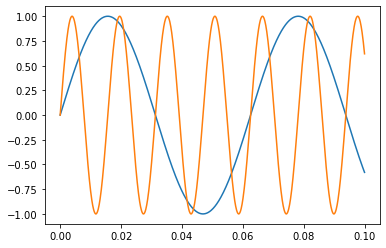

In [4]:
# generate phase time series for inhibitory afferents
t_ser = np.arange(sim_win[0], sim_win[1], 1) / 10000 # seconds
sin_16_ser = np.sin(t_ser*16*2*np.pi)
sin_64_ser = np.sin(t_ser*64*2*np.pi)

fig, ax = plt.subplots()
ax.plot(t_ser[0:1000],sin_16_ser[0:1000])
ax.plot(t_ser[0:1000],sin_64_ser[0:1000])
plt.show()

### 2.2 Calculate action potential threshold voltage

In [5]:
# probability of action potentials by membrane voltage
def ap_prob_func(spk, v, edges):
    null_hist = np.histogram(v, edges)
    spk_hist = np.histogram(v[spk-10], edges)
    spk_cum_prob = np.cumsum(spk_hist[0])
    return {'null': null_hist[0], 'spk': spk_hist[0], 'prob': spk_cum_prob}

def thresh_files_func(sim_dict, sin_ser):
    spk_prob = {}

    # split action potentials based on phase of rhythm
    spk_t = load_spike_h5(sim_dict['APFile'])
    p_inds = np.where(sin_ser >= 0)
    t_inds = np.where(sin_ser < 0)
    spk_t_p = np.intersect1d(spk_t, p_inds)
    spk_t_t = np.intersect1d(spk_t, t_inds)
    
    # load soma voltage
    mem_v = load_v_h5(sim_dict['VMemFile'], 0)

    # calculate action potential probability for each phase
    spk_prob['p'] = ap_prob_func(spk_t_p, mem_v, edges_v)
    spk_prob['t'] = ap_prob_func(spk_t_t, mem_v, edges_v)

    # membrane voltage distribution by phase
    spk_prob['p']['v_dist'] = np.histogram(mem_v[p_inds], edges_v)[0]
    spk_prob['t']['v_dist'] = np.histogram(mem_v[t_inds], edges_v)[0]

    return spk_prob



In [6]:
# process the 16 Hz distal dendritic inhibition simulation
ph_16_prob = thresh_files_func(sim_16_dict, sin_16_ser)

# process the 64 Hz proximal dendritic/somatic inhibition simulation
ph_64_prob = thresh_files_func(sim_64_dict, sin_64_ser)

### 2.3 Plots

In [7]:
# plotting functions
def ap_prob_ph_plot(ph_prob, ax):
        ax.plot(edges_v[1:], ph_prob['p']['prob']/np.max(ph_prob['p']['prob']),color='r')
        ax.plot(edges_v[1:], ph_prob['t']['prob']/np.max(ph_prob['t']['prob']),color='b')

def v_prob_ph_plot(ph_prob, ax):
        ax.plot(edges_v[1:], ph_prob['p']['v_dist']/np.max(ph_prob['p']['v_dist']),color='r')
        ax.plot(edges_v[1:], ph_prob['t']['v_dist']/np.max(ph_prob['t']['v_dist']),color='b')

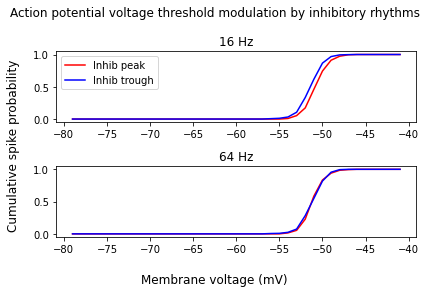

In [10]:
# Action potential probabilities by membrane voltage and phase
fig, ax = plt.subplots(2,1,sharey=True)
ap_prob_ph_plot(ph_16_prob, ax[0])
ap_prob_ph_plot(ph_64_prob, ax[1])
ax[0].set_title('16 Hz')
ax[1].set_title('64 Hz')
fig.suptitle('Action potential voltage threshold modulation by inhibitory rhythms')
fig.supxlabel('Membrane voltage (mV)')
fig.supylabel('Cumulative spike probability')
ax[0].legend(('Inhib peak', 'Inhib trough'))
plt.tight_layout()
fig.savefig('../figures/APVoltDependence.pdf')


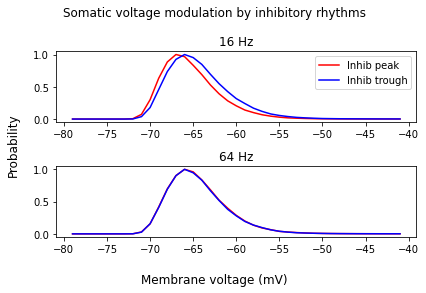

In [9]:
# Membrane voltage by phase
fig, ax = plt.subplots(2,1,sharey=True)
v_prob_ph_plot(ph_16_prob, ax[0])
v_prob_ph_plot(ph_64_prob, ax[1])
ax[0].set_title('16 Hz')
ax[1].set_title('64 Hz')
fig.suptitle('Somatic voltage modulation by inhibitory rhythms')
fig.supxlabel('Membrane voltage (mV)')
fig.supylabel('Probability')
ax[0].legend(('Inhib peak', 'Inhib trough'))
plt.tight_layout()
fig.savefig('../figures/SomaVoltDependence.pdf')